### Creating bathymetry for Lake Zug 

In [1]:
import os
import glob
import pyproj

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [28]:
#path where to save file 
path_out = '/Users/ramajem/Documents/mitgcm/data/input_mitgcm/'

In [2]:
# loading swiss topo files first (resolution is 1km)
path_swisstopo = '/Users/ramajem/Documents/mitgcm/data/input_raw/swissbathy3d_zugersee_2056_5728/' 
files_topo = glob.glob(path_swisstopo + '*.asc')

file_topo = files_topo[10]

In [3]:
# loading x and y files 
path_grid = '/Users/ramajem/Documents/mitgcm/data/input_mitgcm/'

with open(path_grid + 'x.npy', 'rb') as f:
    x = np.load(f)

with open(path_grid + 'y.npy', 'rb') as f:
    y = np.load(f)

In [4]:
# get out variables 
ncols = None
nrows = None
xcorner = None
ycorner  = None
cellsize = None
flag = None 

# Read the file and extract ncols and nrows
with open(file_topo, 'r') as file:
    
    for i in range(6):
        line = file.readline()
        
        if line.startswith('ncols'):
            ncols = int(line.split()[1])
        elif line.startswith('nrows'):
            nrows = int(line.split()[1])
        elif line.startswith('xllcorner'):
            xcorner = int(line.split()[1])
        elif line.startswith('yllcorner'):
            ycorner = int(line.split()[1])
        elif line.startswith('cellsize'):
            cellsize = int(line.split()[1])
        elif line.startswith('nodata_value'):
            flag = int(line.split()[1])

# swiss coordinates for the whole section 
xsc = np.arange(xcorner, (xcorner + (ncols*cellsize)), cellsize)
ysc = np.arange(ycorner, (ycorner + (nrows*cellsize)), cellsize)

#xsc_interp = np.arange(xsc[0],xsc[-1],0.2)
#ysc_interp = np.arange(ysc[0],ysc[-1],0.2)

# extract data (skipping first 6 rows)
data_topo = np.loadtxt(file_topo, skiprows=6)

# Replace values of -999 with NaN
data_topo[data_topo == flag] = np.nan

# coordinates in WGS84         
lv95 = pyproj.CRS('EPSG:2056')  # LV95 / CH1903+
wgs84 = pyproj.CRS('EPSG:4326')  # WGS84
transformer = pyproj.Transformer.from_crs(lv95, wgs84, always_xy=True)

# south west vertex 
lon_corner, lat_corner = transformer.transform(xcorner, ycorner)

# all coordinates 
lon, lat = transformer.transform(xsc, ysc)

# creating xarray
topo = xr.DataArray(
    data_topo,
    coords=[ysc, xsc],
    dims=['ysc', 'xsc'],
)


In [5]:
def extract_topo(filename):
    
    # get out variables 
    ncols = None
    nrows = None
    xcorner = None
    ycorner  = None
    cellsize = None
    flag = None 
    
    # Read the file and extract ncols and nrows
    with open(filename, 'r') as file:
        
        for i in range(6):
            line = file.readline()
            
            if line.startswith('ncols'):
                ncols = int(line.split()[1])
            elif line.startswith('nrows'):
                nrows = int(line.split()[1])
            elif line.startswith('xllcorner'):
                xcorner = int(line.split()[1])
            elif line.startswith('yllcorner'):
                ycorner = int(line.split()[1])
            elif line.startswith('cellsize'):
                cellsize = int(line.split()[1])
            elif line.startswith('nodata_value'):
                flag = int(line.split()[1])
    
    # swiss coordinates for the whole section 
    xsc = np.arange(xcorner, (xcorner + (ncols*cellsize)), cellsize)
    ysc = np.arange(ycorner, (ycorner + (nrows*cellsize)), cellsize)

    
    # extract data (skipping first 6 rows)
    data_topo = np.loadtxt(filename, skiprows=6)
    data_topo = np.flip(data_topo, axis=0) #need to flip because somewhere along the way something is funky
    
    # Replace values of -999 with NaN
    data_topo[data_topo == flag] = np.nan
    
    # creating xarray 

    #swiss coordinates
    topo = xr.DataArray(
        data_topo,
        coords=[ysc, xsc],
        dims=['ysc', 'xsc'],)

    
    return (topo)
    
        

Extract and concatenate files from Swiss topo

In [6]:
# loading swiss topo files first (resolution is 1km)
path_swisstopo = '/Users/ramajem/Documents/mitgcm/data/input_raw/swissbathy3d_zugersee_2056_5728/' 
files_topo = glob.glob(path_swisstopo + '*.asc')

all_topo = []

for file in files_topo:
    topo = extract_topo(file)
    all_topo.append(topo)

all_topo = xr.combine_by_coords(all_topo)

In [7]:
# get max elevation 
all_topo.where(all_topo == all_topo.max(), drop=True)

<xarray.DataArray (ysc: 1, xsc: 1)> Size: 8B
array([[440.75]])
Coordinates:
  * ysc      (ysc) int64 8B 1218749
  * xsc      (xsc) int64 8B 2679244

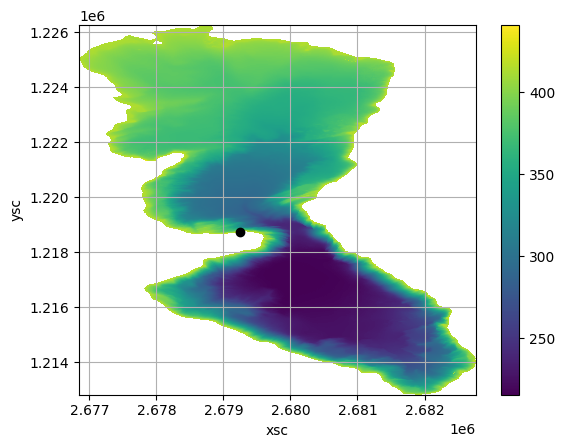

In [8]:
all_topo.plot()
plt.scatter(2679244, 1218749,color='k')
plt.grid()

#### 417m is average altitude of Lake Zug

In [9]:
all_bathy = all_topo - 417
all_bathy.load()

<xarray.DataArray (ysc: 13443, xsc: 5917)> Size: 636MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * ysc      (ysc) int64 108kB 1212816 1212817 1212818 ... 1226257 1226258
  * xsc      (xsc) int64 47kB 2676848 2676849 2676850 ... 2682763 2682764

Set topo as bathy (altitude at Lake Zug should be set to 0 and everything below is set to negative)

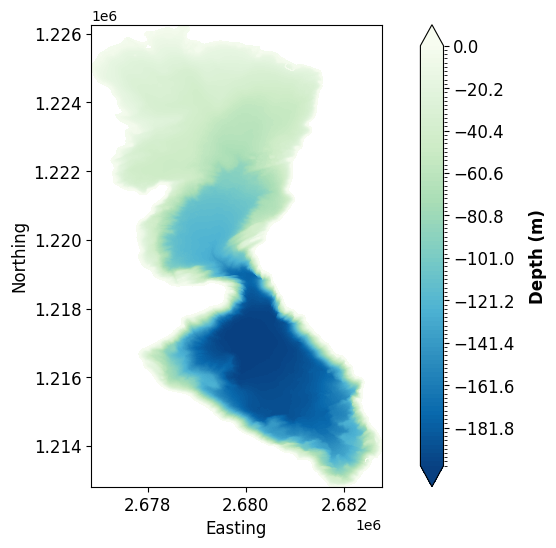

In [10]:
lsize = 12
fig, ax = plt.subplots(figsize=(5, 6))

cax = all_bathy.plot.contourf(vmax=0,vmin=-200,cmap='GnBu_r',add_colorbar=False,levels=100)

# Add a horizontal colorbar with the label and set its font properties
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Depth (m)', fontsize=lsize, fontweight='bold', labelpad=10)  # Adjust font size, weight, and padding as needed
cbar.ax.tick_params(labelsize=lsize)  # Set the colorbar tick label size

plt.xlabel('Easting', fontsize=lsize)
plt.ylabel('Northing', fontsize=lsize)

ax.tick_params(axis='both', which='major', labelsize=lsize)  


#### activate cell below to plot out location of CTDs on top of bathymetry map

lsize = 20
fig, ax = plt.subplots(figsize=(10, 14))

cax = all_bathy.plot.contourf(vmax=0,vmin=-200,cmap='GnBu_r',add_colorbar=False,levels=100)
plt.scatter(2680461,1216988,label='CTD1',color='k')
plt.scatter(2680159,1217784,label='CTD2',color='k')
plt.scatter(2680127, 1218654,label='CTD3',color='k')
plt.scatter(2679373,1220121,label='CTD4',color='k')
plt.legend()

Creating wall around shoreline

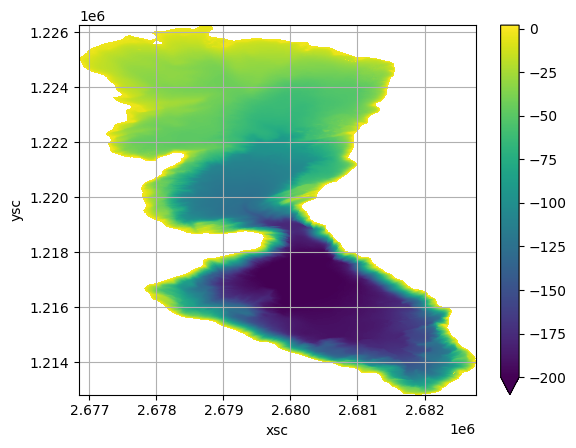

In [11]:
all_bathy = np.minimum(all_bathy, np.zeros(np.shape(all_bathy)))
all_bathy += 2 * (all_bathy > -0.01)
all_bathy.plot(vmax=2,vmin=-200)
plt.grid()

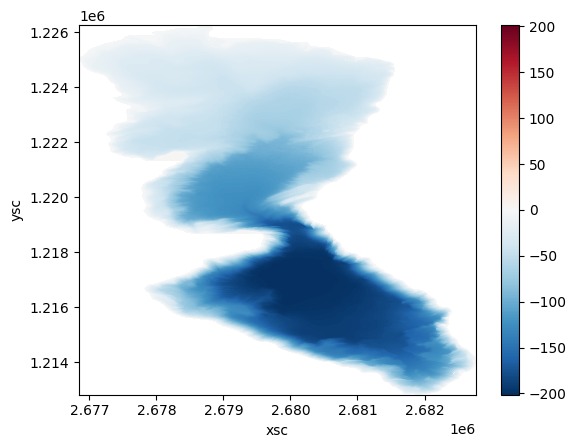

In [12]:
# interpolate over nans in middle of lake 
all_bathy = all_bathy.interpolate_na(dim='xsc')
all_bathy.plot()

## Setting origin point as 0,0

In [13]:
# South west vortex 
xgOrigin = all_bathy.xsc.values[0]
ygOrigin = all_bathy.ysc.values[0]

# North east vortex 
xgEnd = all_bathy.xsc.values[-1]
ygEnd = all_bathy.ysc.values[-1]

xdiff = xgEnd - xgOrigin
ydiff = ygEnd - ygOrigin

# moving point of orgin slightly south and west
xgOrigin = xgOrigin - 200
ygOrigin = ygOrigin - 400

# setting xgOrigin and ygOrigin as 0,0
xgrid = all_bathy.xsc.values - xgOrigin
ygrid = all_bathy.ysc.values - ygOrigin

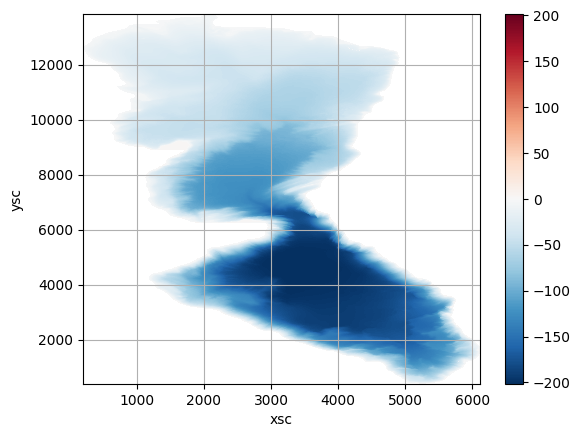

In [14]:
bathy_grid = all_bathy
bathy_grid["xsc"] = xgrid
bathy_grid["ysc"] = ygrid

bathy_grid.plot()
plt.grid()

#### Interpolate grid

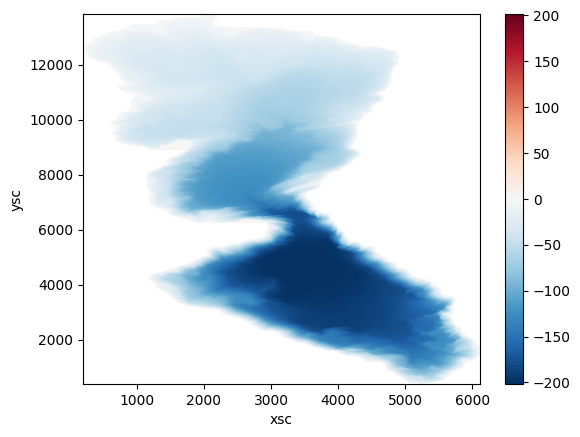

In [15]:
### grid values

nan_bathy = all_bathy.notnull().astype(float)

bathy_grid_interp = bathy_grid.interp({'xsc':x,'ysc':y},method="linear")
nan_bathy_interp = nan_bathy.interp({'xsc':x,'ysc':y},method="linear")
nan_bathy_interp =  nan_bathy_interp.fillna(0)


bathy_grid.plot()

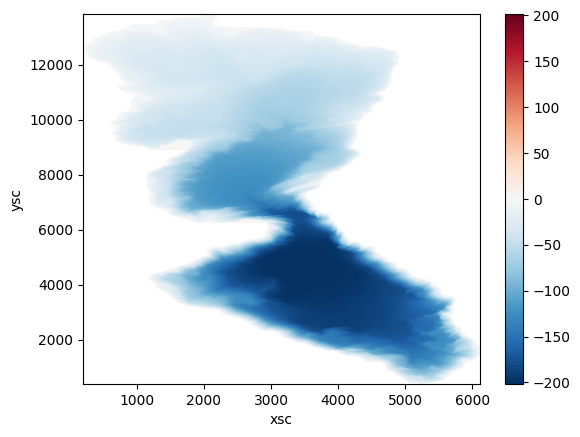

In [16]:
bathy_grid.interpolate_na(dim='xsc').plot()


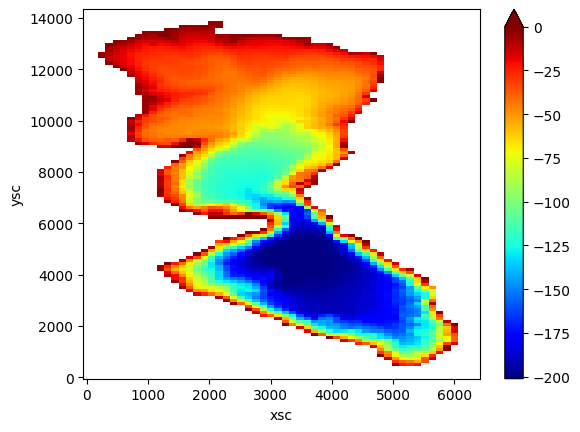

In [17]:
bathy_grid_interp.plot(vmax=0,cmap='jet')


### Interpolate over nans (inside of lake)

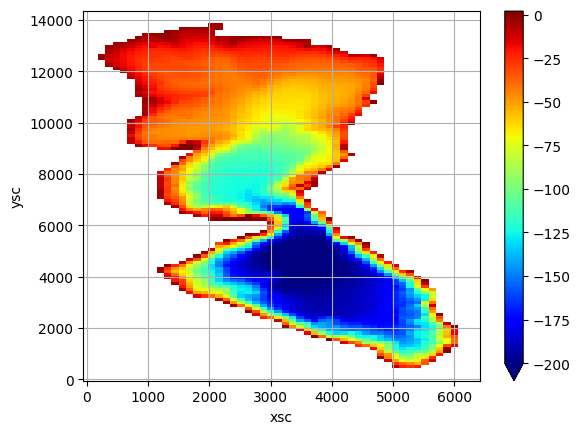

In [18]:
bathy_grid_interp = bathy_grid_interp.interpolate_na(dim="xsc", method="linear")
bathy_grid_interp.plot(vmax=2,vmin=-200,cmap='jet')
plt.grid()

### some really shallow - almost 'land like' spots inside lake
- replacing those by -5m??

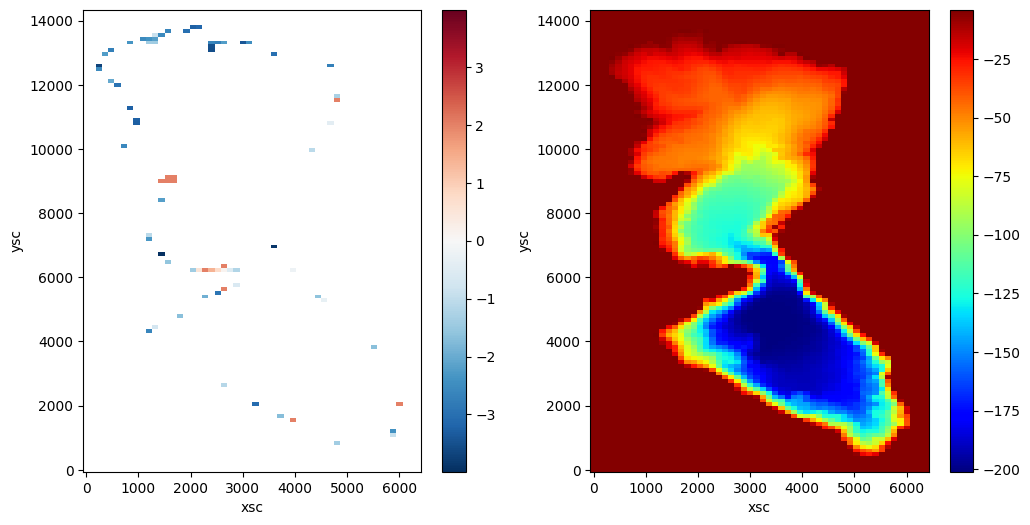

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

bathy_grid_interp.where(bathy_grid_interp > -4).plot(ax=ax1)
plt.grid()

bathy_grid_interp = bathy_grid_interp.where(bathy_grid_interp < -4, -5) #changes also nans
bathy_grid_interp.plot(ax=ax2,cmap='jet')

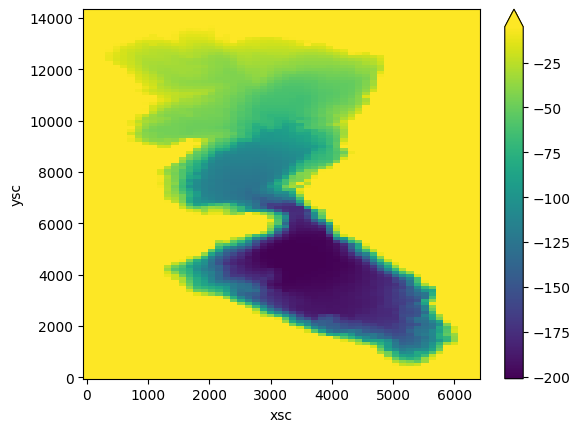

In [20]:
# Factor in 0s again
bathy_grid_interp = bathy_grid_interp*nan_bathy_interp
bathy_grid_interp.plot(vmax=-5)

### Setting zeros to something positive (that is setting non-water to land)

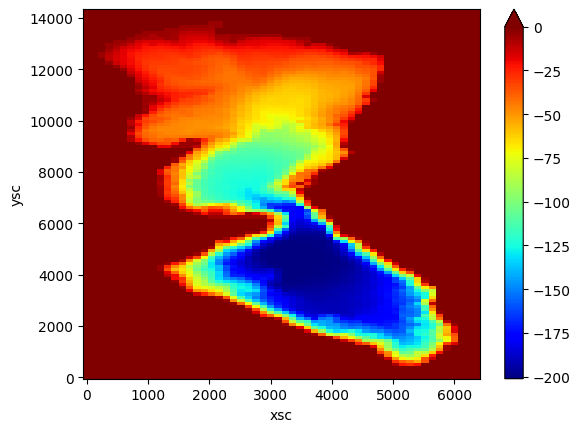

In [21]:
bathy_grid_filled = bathy_grid_interp.where(bathy_grid_interp <= -1 ,2)
bathy_grid_filled.plot(vmax=0,cmap='jet')



### Smooth out transitions in depth?
- not sure, need to check this out 

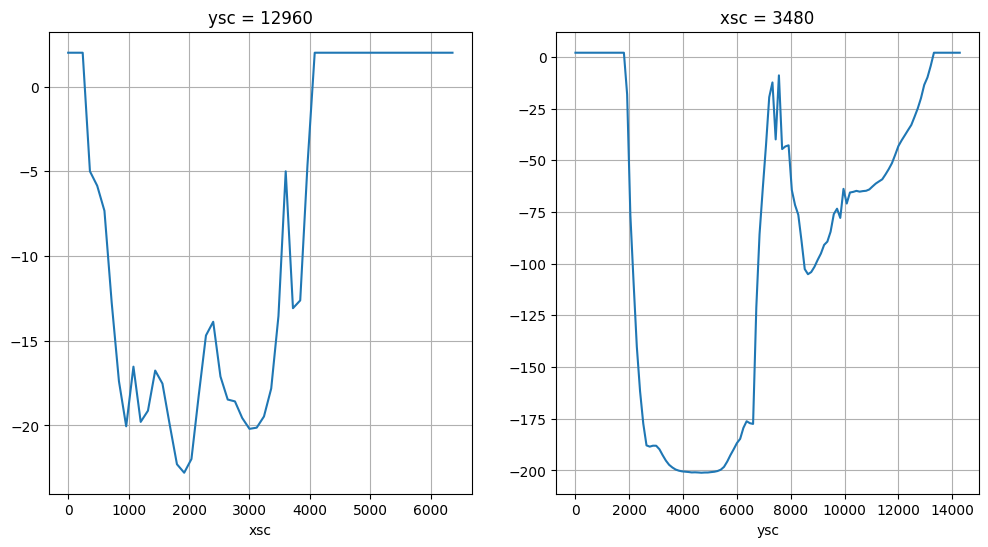

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

bathy_grid_filled.sel(ysc=13000,method='nearest').plot(ax=ax1)
ax1.grid()

bathy_grid_filled.sel(xsc=3500,method='nearest').plot(ax=ax2)
ax2.grid()

In [29]:
# saving bathy file 

def write_binary(path_fname,data):
    '''
    Saves data in the right binary format for MITgcm, in the dimension order XYT
    Output binary files have been read and tested 
    '''

    data = data.to_numpy() #convert to xarray to numpy first - and then save to binary
    dtype = '>f8'  # big-endian and precision 64 (small-endian with precision 32 is '<f4')
    data = data.astype(dtype)

    # Write to file
    fid = open(path_fname, 'wb')
    data.tofile(fid)
    fid.close()

    
bathy_grid_filled = bathy_grid_filled.transpose('xsc','ysc')
write_binary(path_out + 'bathy.bin',bathy_grid_filled)